In [1]:
from data.wider_face import *
from data.preprocess import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from config import *
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
dataset = WiderFaceDataset(split = 'train')
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=4)

==> initializing centerface key point train data.
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
Loaded train 12671 samples


In [4]:
# for i_batch, sample_batched in enumerate(dataloader):
#     print('batch', i_batch)
#     for key in sample_batched.keys():
#         print('key:', key)
#         print(sample_batched[key].shape)
#     print()

#     # # observe 4th batch and stop.
#     # if i_batch == 3:
#     #     # plt.figure()
#     #     # # show_landmarks_batch(sample_batched)
#     #     # plt.axis('off')
#     #     # plt.ioff()
#     #     # plt.show()
#     #     break


1005 1513


(3, 800, 800)

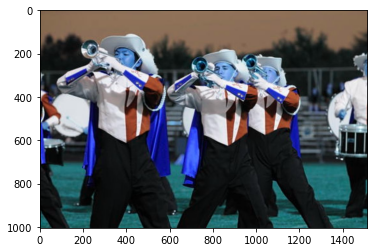

In [14]:
# gaussian not right with index 300

index = 301
res = dataset.__getitem__(index)
res['input'].shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


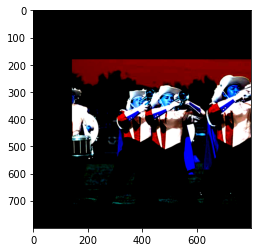

In [15]:
input = res['input'].transpose(1,2,0)
plt.imshow(input)

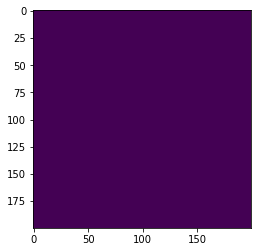

In [18]:
# plt.imshow(res['hm_hp'][0])
# plt.imshow(res['hm'][0])
combine_gaussian = np.zeros((200,200))
for gau in res['hm_hp']:
    combine_gaussian += gau

plt.imshow(combine_gaussian)

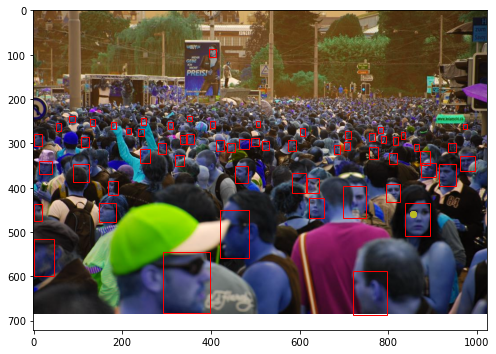

In [68]:
bbox = []

def visualize_item(index):
    img_id = dataset.images[index]
    file_name = dataset.coco.loadImgs(ids=[img_id])[0]['file_name']
    img_path = os.path.join(dataset.img_dir, file_name)
    ann_ids = dataset.coco.getAnnIds(imgIds=[img_id])
    anns = dataset.coco.loadAnns(ids=ann_ids)
    num_objs = len(anns)

    img = cv2.imread(img_path)
    
    fig, ax = plt.subplots()

    ax.imshow(img)
    
    

    for ann in anns:
        # the segmentation are in format (x1, y1, x2, y2) (top left and bottom right points) 
        # (after convert from coco format to box format)
        # coco format (top left x, top left y, width, height)
        x1 = ann['segmentation'][0]
        y1 = ann['segmentation'][1]
        x2 = ann['segmentation'][2]
        y2 = ann['segmentation'][3]

        plt.scatter(anns[0]['keypoints'][0], anns[0]['keypoints'][1])
        
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # ann = anns[0]
    # x1 = ann['segmentation'][0]
    # y1 = ann['segmentation'][1]
    # x2 = ann['segmentation'][2]
    # y2 = ann['segmentation'][3]

    # # h, w of bbox
    # bbox.append(y2 - y1)
    # bbox.append(x2 - x1)
    # rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
    
    # plt.scatter(ann['keypoints'][2], ann['keypoints'][2])
    
    plt.show()

visualize_item(index)

In [ ]:
def gaussian_radius(det_size, min_overlap=0.7):
  height, width = det_size

  a1  = 1
  b1  = (height + width)
  c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  r1  = (b1 + sq1) / 2

  a2  = 4
  b2  = 2 * (height + width)
  c2  = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  r2  = (b2 + sq2) / 2

  a3  = 4 * min_overlap
  b3  = -2 * min_overlap * (height + width)
  c3  = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3  = (b3 + sq3) / 2
  return min(r1, r2, r3)


def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1                                         # 直径
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]         # 对那个区域进行赋值   Assign a value to that area
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap

def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap


def draw_msra_gaussian(heatmap, center, sigma):
  tmp_size = sigma * 3
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

### Test data anchor 

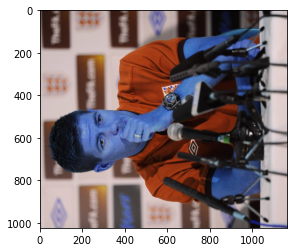

In [106]:
from data.utils import Data_anchor_sample
from data.augment import *

img = cv2.imread('/Users/hainguyen/Documents/deep_learning_projects/datasets/wider_face/WIDER_train/images/9--Press_Conference/9_Press_Conference_Press_Conference_9_19.jpg')
plt.imshow(img)

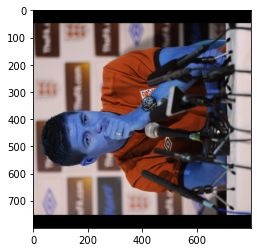

In [107]:
c = np.array([img.shape[1] / 2., img.shape[0] / 2.], dtype=np.float32)
s = max(img.shape[0], img.shape[1]) * 1.0
rot = 0
input_res = 800

trans_input = get_affine_transform(c, s, rot, [input_res, input_res])
inp = cv2.warpAffine(img, trans_input, (input_res, input_res), flags=cv2.INTER_LINEAR)

inp = (inp.astype(np.float32) / 255.)
inp = inp.transpose(2, 0, 1)

plt.imshow(inp.transpose(1,2,0))

In [1]:
from models.model import *

thisdict = {
    'hm': 1,
    'wh': 2,
    "hm_offset": 2,
    "landmarks": 10
}
model = MobileNetSeg(base_name='mobilenetv2_10', heads=thisdict)
# model

MobileNetSeg heads:
{'hm': 1, 'wh': 2, 'hm_offset': 2, 'landmarks': 10}

Base input channel: 32
output channel 0: 16
output channel 1: 24
output channel 2: 32
output channel 3: 64
output channel 4: 96
output channel 5: 160
output channel 6: 320
Base feature channel: [24, 32, 96, 320]
MobileNetSeg channels: [24, 32, 96, 320]
MobileNetUp channels: [320, 96, 32, 24]
IDAUp channel: 96
IDAUp channel: 32
IDAUp channel: 24
fc shape: 2


In [2]:
 import torch
 x = torch.tensor([1, 2, 3, 4])
 x.shape

torch.Size([4])

In [6]:
a = torch.unsqueeze(x, 0)
a

tensor([[1, 2, 3, 4]])

In [6]:
%run test_args.py --b 10

3
